# Group 6 Project

In [1]:
from datasets import load_dataset
import plotly.express as px
from itertools import chain
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
# Login using e.g. `huggingface-cli login` to access this dataset  (run this in console, with venv activated)

dataset = load_dataset("mteb/twentynewsgroups-clustering", revision="6125ec4e24fa026cec8a478383ee943acfbd5449")
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})


In [3]:
print(dataset.keys())

dict_keys(['test'])


### Extracting variables:

In [4]:
test = dataset["test"]
texts_sep = list(test["sentences"])
labels_sep = list(test["labels"])

## Understanding the Dataset

In [5]:
print(test[0].keys())
print(len(test))

print(test[0]["sentences"][0], '=>', test[0]["labels"][0])
print(test[0]["sentences"][1], '=>', test[0]["labels"][1])
print(test[0]["sentences"][2], '=>', test[0]["labels"][2])

# each sentence and which group it belongs to

dict_keys(['sentences', 'labels'])
10
Motorola MC143150 and MC143120 => 12
Windows 3.1(new) for sale $35 => 6
Gospel Dating => 0


In [6]:
total = set()
for i in range(len(test)):
    total = total.union(set(test[i]["labels"]))
total  # there are around 20 groups

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [7]:
texts = []
for text in texts_sep:
    texts.extend(text)
print("number of texts: ", len(texts))

number of texts:  59545


In [8]:
labels_list = list(chain.from_iterable(labels_sep))
label_counts = OrderedDict(sorted(Counter(labels_list).items()))
len(labels_list)  # total records in general

59545

In [9]:
px.bar(x=[str(_) for _ in label_counts.keys()], y=label_counts.values(), labels={"x": "labels", "y": "count of appearance"})

In [10]:
get_from = lambda x: [texts[i] for i, val in enumerate(labels_list) if val == x]
get_word_cloud = lambda x: WordCloud(stopwords=STOPWORDS, max_words=100).generate(x)

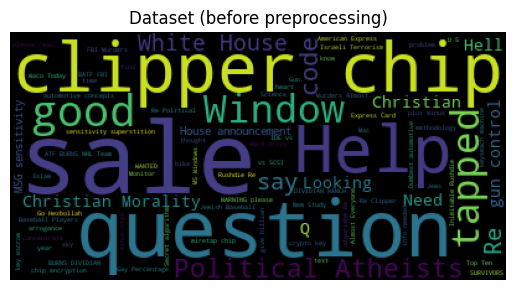

In [11]:
# before preprocessing

cloud = get_word_cloud(" ".join(texts))
plt.title("Dataset (before preprocessing)")
plt.axis("off")
plt.imshow(cloud)

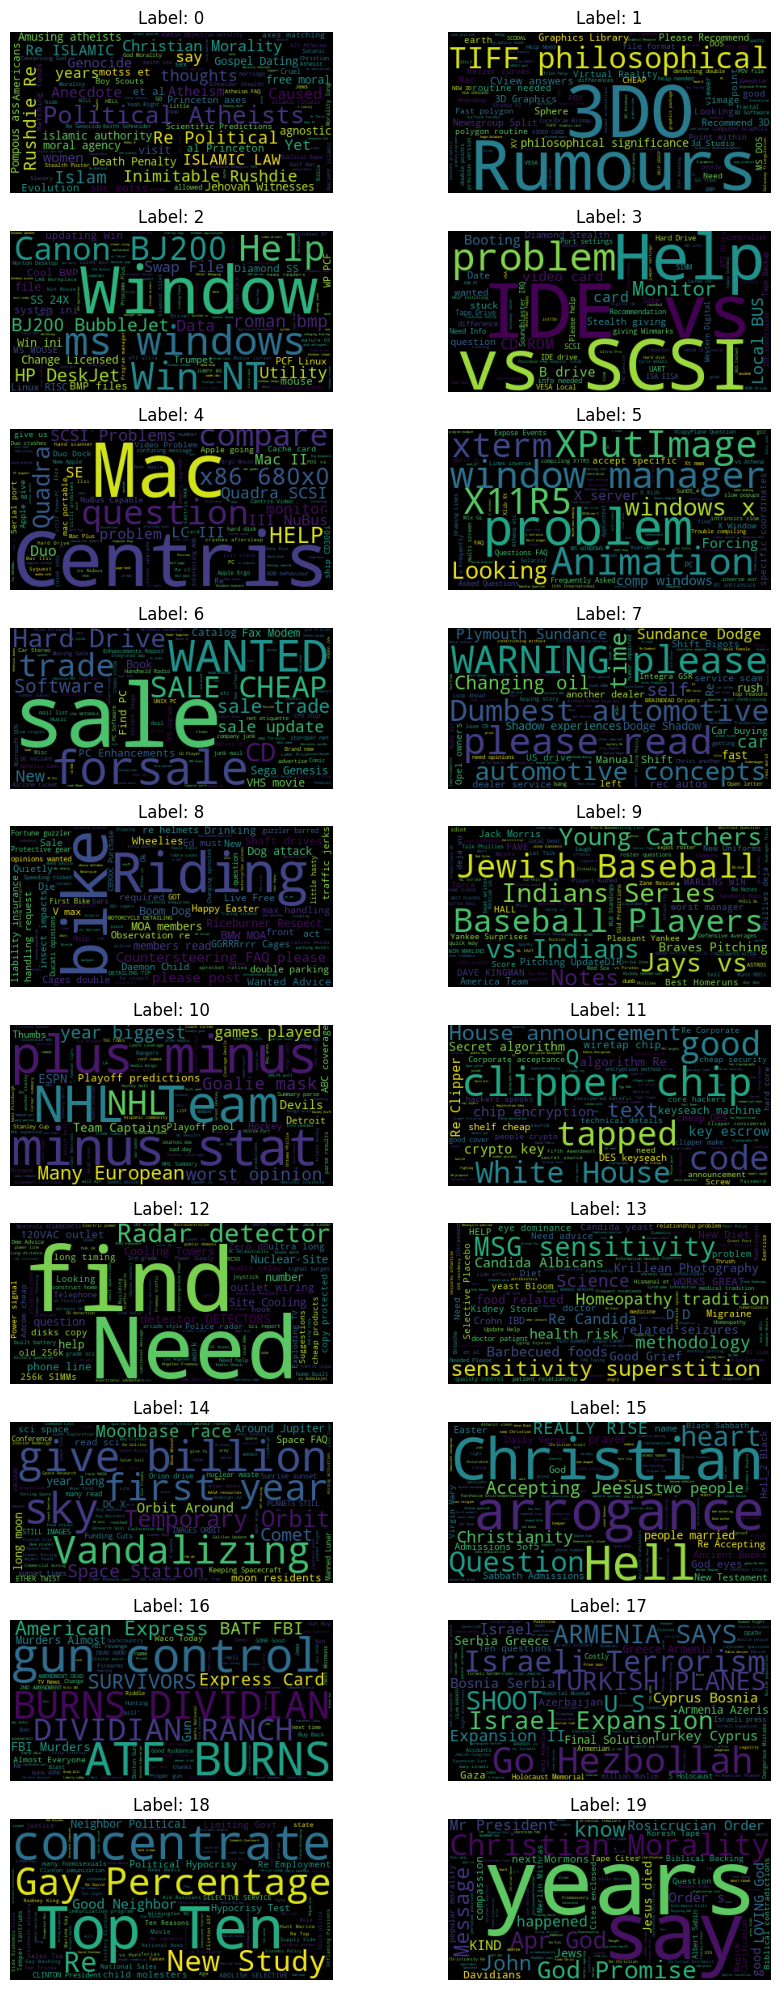

In [12]:
fig, _axs = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

for _ in range(20):
    axs[_].imshow(get_word_cloud(" ".join(get_from(_))))
    axs[_].set_title(f"Label: {_}")
    axs[_].axis("off")
fig.tight_layout()
plt.show()

## Preprocessing

In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
print(embeddings.shape)
print(embeddings[0][0:20])

(59545, 384)
[-0.10949051  0.01752549  0.06833325 -0.0504889   0.01307427 -0.01668743
 -0.02064353  0.03873769 -0.03209924  0.016407    0.10264194  0.01111447
  0.07978289 -0.01114768 -0.04782147  0.01050704  0.01809989 -0.02259755
  0.08697542  0.01350243]


In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2 ** 6)  #64
features = pca.fit_transform(embeddings)

In [16]:
print(features.shape)

(59545, 64)


In [17]:
test_features = features[0:10000]
print(test_features.shape)
print(test_features[9])

(10000, 64)
[-0.03578572 -0.03294921 -0.2135972   0.06858742  0.09796464  0.05993736
  0.1594515   0.24713874 -0.1793809  -0.11295338  0.2899509  -0.08548094
 -0.09517146 -0.10904061 -0.01815843  0.06955553  0.24568927  0.04191928
  0.09513504 -0.06501768  0.01594953  0.09525616 -0.06524366 -0.06739256
  0.04816995 -0.03976784  0.07842852 -0.08184901 -0.04945645 -0.0026669
  0.09293792 -0.09974931  0.01910411 -0.13573934 -0.01880692  0.071775
  0.11394059  0.07375348  0.04549301  0.13630095 -0.07881506  0.08253065
  0.01053144  0.03884207 -0.01578242 -0.06864854 -0.05302563 -0.00159172
 -0.13450557 -0.04096977  0.14991274 -0.05403659 -0.03791624  0.02688804
  0.04480883  0.08370027 -0.10620668  0.03845965 -0.10670219  0.06824949
 -0.07485165 -0.00415794  0.02452324  0.03259228]


In [18]:
from src.DBScan import DBScan

scanner =  DBScan(radius=0.6, min_dense=10)
clusters = scanner.make_clusters(features)

In [19]:
import numpy as np
print("Number of clusters produced: ", np.unique(clusters).size)
print(len(np.where(clusters==0)))

Number of clusters produced:  611
1


### Using the DBScan elbow method

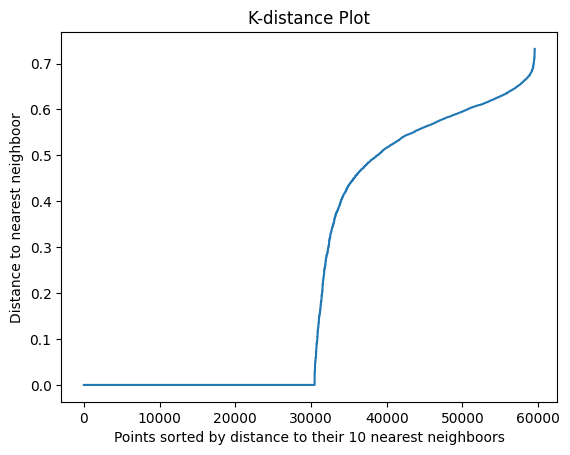

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from src.NearestNeighbours import NearestNeighbours

# This approach uses our implementation of NearestNeighbours and takes 3 min

k_nearest_neigbours = 15
all_distances = []

nearest_neighbours = NearestNeighbours(k_nearest_neigbours).fit(features)
for i in range(len(features)):
    all_distances.append(nearest_neighbours.get_kth_nearest_neighbor_distance(i))

distances_sorted = np.sort(all_distances)

plt.plot(distances_sorted)

plt.xlabel("Points sorted by distance to their 10 nearest neighboors")
plt.ylabel("Distance to nearest neighboor")
plt.title("K-distance Plot")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix

# This uses scipy and takes 15 min to run!

k_nearest_neigbours = 3
all_distances = []

all_features = np.asarray(features, dtype=np.float16)

distance_matrix_features = distance_matrix(all_features, all_features)
np.fill_diagonal(distance_matrix_features, np.inf)

k_distance = np.partition(distance_matrix_features, k_nearest_neigbours, axis=1)[:, k_nearest_neigbours]

sorted_distances = np.sort(k_distance)

plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance to their 10 nearest neighboors")
plt.ylabel("Distance to nearest neighboor")
plt.title("K-distance Plot")

plt.show()
